In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import timedelta

In [40]:
# Veriyi oku
df = pd.read_csv(r'C:\Users\realb\Desktop\Facebook hisse fiyatı tahmin modeli\FB_stock_history.csv')

In [41]:
# Tarih sütununu datetime formatına çevir ve veriyi tarihine göre sırala
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [42]:
# Kapanış fiyatlarını al ve normalize et
closing_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

In [43]:
# LSTM modeli için veriyi hazırla
def prepare_lstm_data(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = prepare_lstm_data(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [44]:
# Veriyi eğitim ve test setlerine ayır
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [45]:
# LSTM modelini tanımla
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

In [46]:
# Modeli derle
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
# Modeli eğit
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
58/58 [==============================] - 4s 28ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 2/50
58/58 [==============================] - 1s 18ms/step - loss: 9.1564e-04 - val_loss: 0.0039
Epoch 3/50
58/58 [==============================] - 1s 18ms/step - loss: 7.2169e-04 - val_loss: 0.0041
Epoch 4/50
58/58 [==============================] - 1s 18ms/step - loss: 6.9783e-04 - val_loss: 0.0044
Epoch 5/50
58/58 [==============================] - 1s 18ms/step - loss: 6.5646e-04 - val_loss: 0.0023
Epoch 6/50
58/58 [==============================] - 1s 18ms/step - loss: 6.2191e-04 - val_loss: 0.0030
Epoch 7/50
58/58 [==============================] - 1s 18ms/step - loss: 5.3620e-04 - val_loss: 0.0014
Epoch 8/50
58/58 [==============================] - 1s 19ms/step - loss: 5.8550e-04 - val_loss: 0.0019
Epoch 9/50
58/58 [==============================] - 1s 19ms/step - loss: 4.7669e-04 - val_loss: 0.0023
Epoch 10/50
58/58 [==============================] - 1s 18ms/step - loss: 4.1

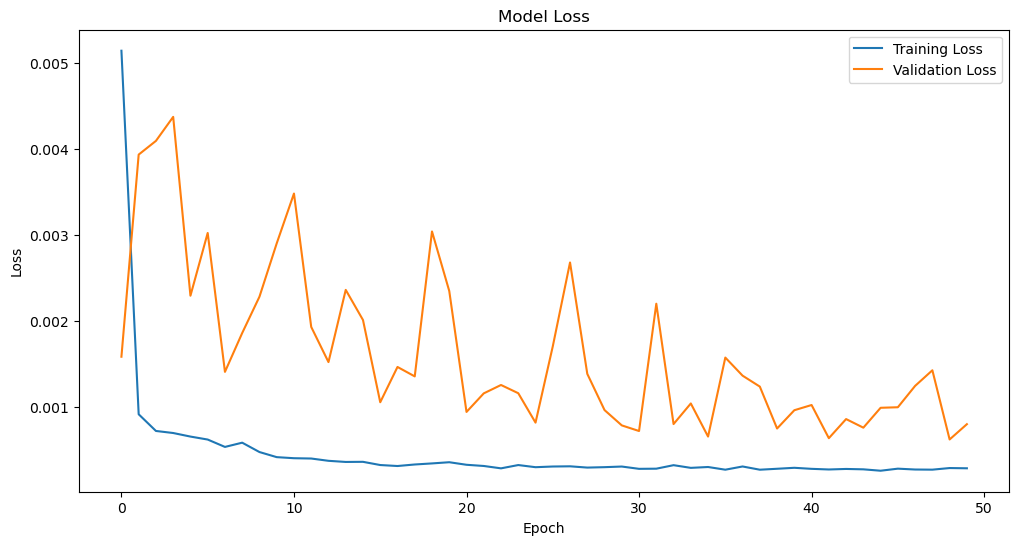

In [48]:
# Eğitim ve doğrulama kayıplarını çiz
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Test verisinde tahmin yap
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

15/15 [==============================] - 1s 6ms/step


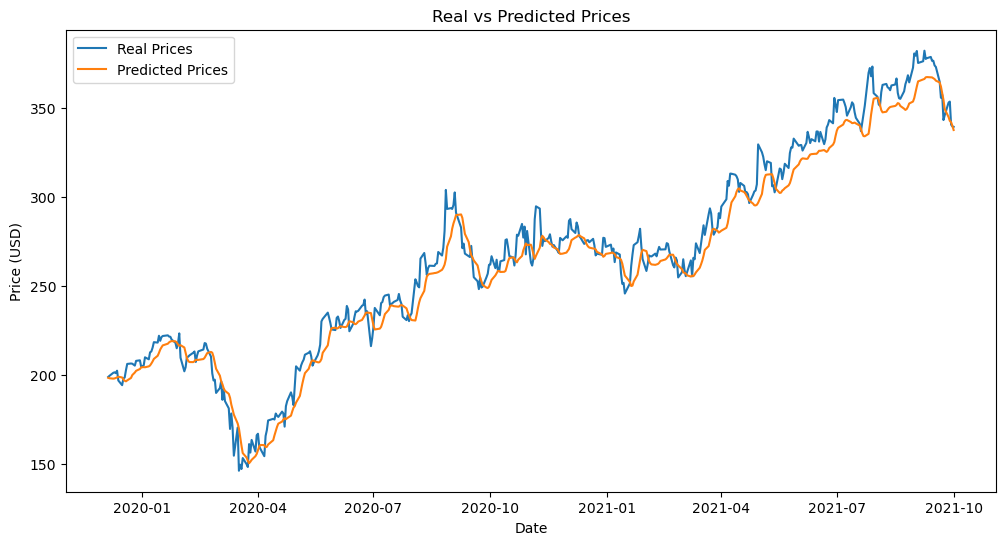

In [50]:
# Gerçek ve tahmin edilen fiyatları karşılaştır
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(real_prices):], real_prices, label='Real Prices')
plt.plot(df['Date'][-len(predicted_prices):], predicted_prices, label='Predicted Prices')
plt.title('Real vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [51]:
# Tahmin için gerekli veri
temp_input = list(scaled_data[-time_step:].flatten())

In [52]:
# Bir yıllık tahmin yapmak için gerekli adımlar
future_predictions = []
for i in range(365):
    temp_input_array = np.array(temp_input).reshape((1, time_step, 1))
    predicted_price = model.predict(temp_input_array, verbose=0)
    temp_input = temp_input[1:]
    temp_input.append(predicted_price[0, 0])
    future_predictions.append(predicted_price[0, 0])

In [53]:
# Tahminleri orijinal fiyat ölçeğine geri dönüştür
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [54]:
# Tahmin edilen tarihleri oluştur
last_date = df['Date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 366)]

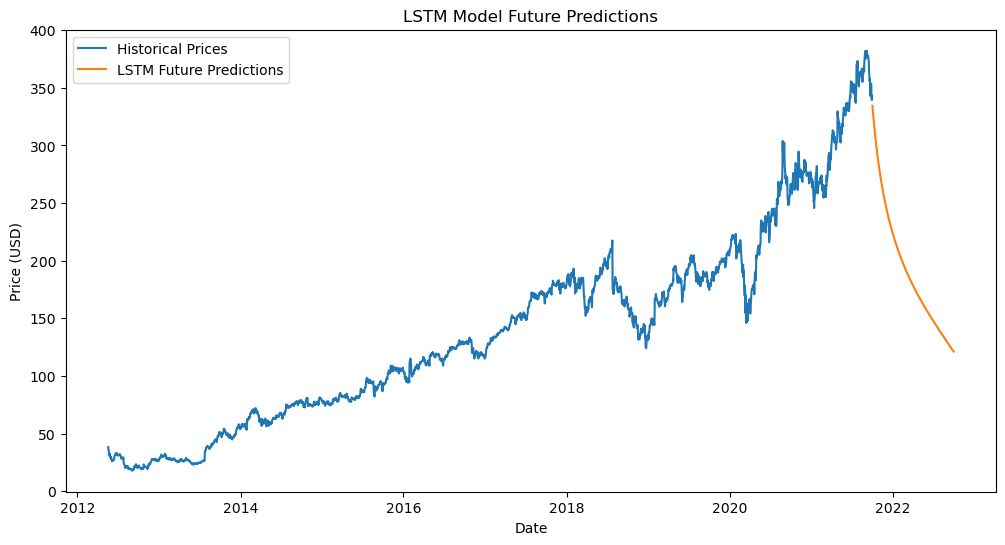

In [55]:
# Tahminleri çiz
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Historical Prices')
plt.plot(future_dates, future_predictions, label='LSTM Future Predictions')
plt.title('LSTM Model Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

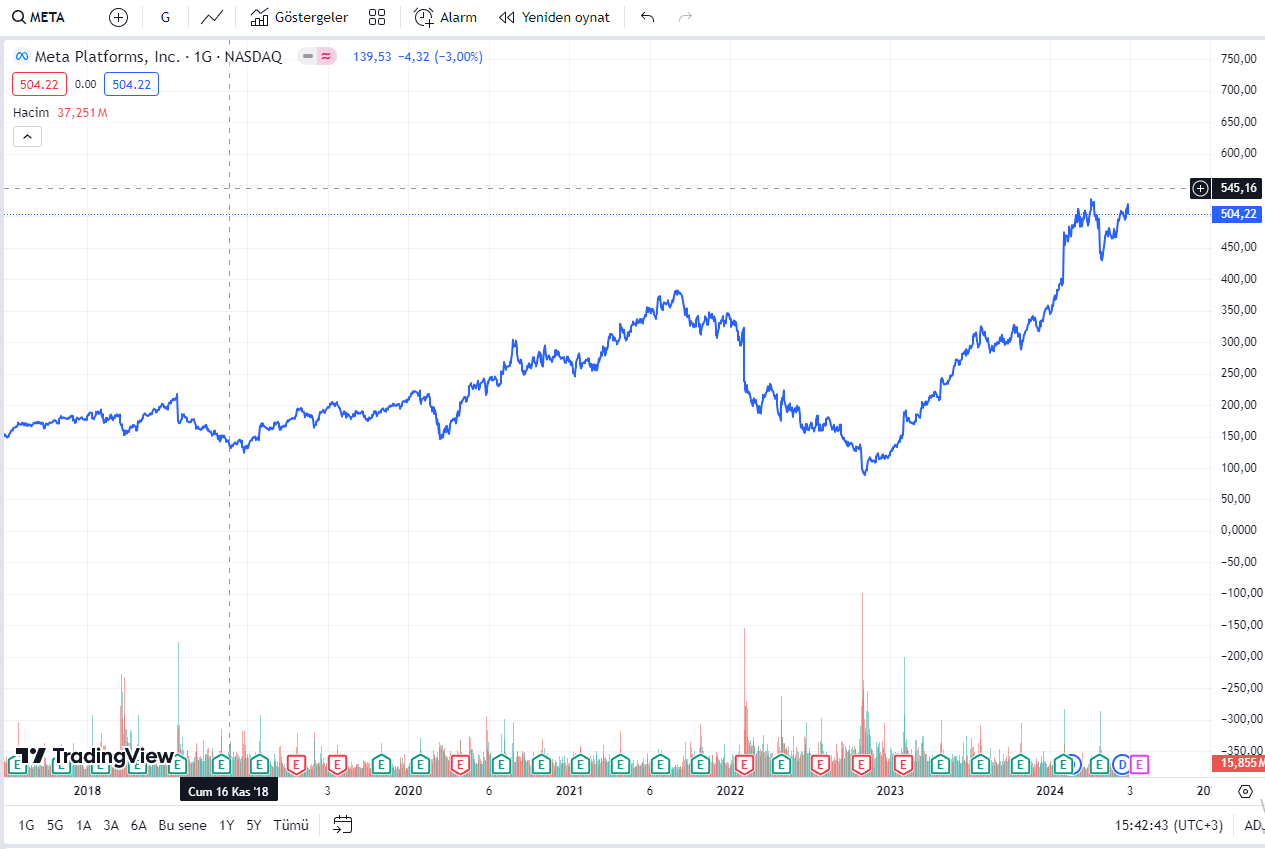

In [57]:
from IPython.display import Image

# Resmin dosya yolunu belirtelim
file_path = r'C:\Users\realb\Desktop\Facebook hisse fiyatı tahmin modeli\Ekran görüntüsü 2024-06-30 15344.png'

# Resmi gösterelim
Image(filename=file_path)

In [58]:
# Gerçek ve tahmin edilen fiyatları karşılaştırarak MSE hesapla
mse = mean_squared_error(real_prices, predicted_prices)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 106.31134848036885
